# RCNN for legend detection 

This is an adaption of [this tutorial](https://johschmidt42.medium.com/train-your-own-object-detector-with-faster-rcnn-pytorch-8d3c759cfc70).  

In [1]:
import os 
from PIL import Image 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patches as patches 

import torch 
import pathlib 
from skimage.io import imread 
from torchvision.ops import box_convert 
from typing import List, Dict 
import pathlib 
import cv2 

import multiprocessing 

# Prepare data 

In [2]:
!wget https://osf.io/4pvqu/download -O bboxes.zip 
if not os.path.exists("bboxes"): 
    !unzip bboxes.zip # bounding boxes (csvs) 

!wget https://osf.io/5fv4u/download -O corpora.zip 
if not os.path.exists("corpora"): 
    !unzip corpora.zip # actual charts (pngs) 
    
!wget https://osf.io/ah3zs/download -O sample.pt # model 

--2021-12-03 00:00:20--  https://osf.io/4pvqu/download
Resolving osf.io... 35.190.84.173
Connecting to osf.io|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/ztv7p/providers/osfstorage/618ed877857b44000edd0d8b?action=download&direct&version=1 [following]
--2021-12-03 00:00:21--  https://files.osf.io/v1/resources/ztv7p/providers/osfstorage/618ed877857b44000edd0d8b?action=download&direct&version=1
Resolving files.osf.io... 35.186.214.196
Connecting to files.osf.io|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115643 (113K) [application/octet-stream]
Saving to: ‘bboxes.zip’

bboxes.zip          100%[===================>] 112,93K  --.-KB/s    in 0,03s   

2021-12-03 00:00:22 (4,25 MB/s) - ‘bboxes.zip’ saved [115643/115643]

--2021-12-03 00:00:22--  https://osf.io/5fv4u/download
Resolving osf.io... 35.190.84.173
Connecting to osf.io|35.190.84.173|:443... connected.
HTTP 

In [3]:
datapath = "corpora/" 
bboxes = "bboxes/" 

def load_data(datapath = datapath, bboxespath = bboxes, n_files = 99): 
    """ 
    Load `n_files` from `datapath`; the csv containing the 
    bounding boxes are presumably in `bboxespath`. 
    """ 
    data = {
        "filename": list(),  
        "array": list() 
    } 
    
    files = os.listdir(datapath) 
    
    for i, file in enumerate(files): 
        # if i > n_files: return data 
        try: 
            if file.endswith(".png"): 
                legbboxes = pd.read_csv(bboxespath + file.replace(".png", "-bbs.csv")) 
                data["array"].append(legbboxes) 
                data["filename"].append(file) 
        except FileNotFoundError: 
            continue 
    
    return data 

In [4]:
folders = os.listdir(datapath)  

data = {
    "filename": list(), 
    "bbox": list() 
} 
for folder in folders: 
    folder = folder + "/" 
    currdata = load_data(datapath = datapath + folder, bboxespath = bboxes + folder)      
    data["filename"] = data["filename"] + \
        [folder + "/" + filename for filename in currdata["filename"]]  
    data["bbox"] = data["bbox"] + currdata["array"]  

print("Instances:", len(data["bbox"]))  

Instances: 278


Training data


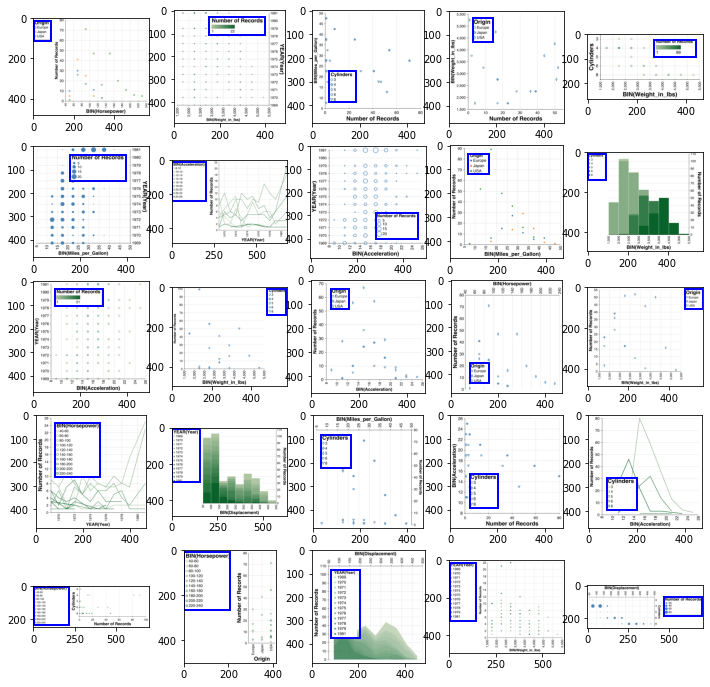

In [5]:
_, axs = plt.subplots(5, 5, figsize = (12, 12))  
axs = axs.flatten() 
naxs = axs.shape[0] 
for bbox, imgpath, ax in zip(data["bbox"][:naxs], data["filename"][:naxs], axs): 
    img = plt.imread(datapath + imgpath)
    x, y, width, height = bbox[["x", "y", "width", "height"]].to_numpy()[0] 
    rect = patches.Rectangle((x, y), width, height, linewidth = 2, 
                            facecolor = "none", edgecolor = "blue") 
    ax.imshow(img) 
    ax.add_patch(rect) 
print("Training data") 
plt.show() 

In [6]:
def reshape_data(data: dict): 
    """ 
    Reshape data `data` to be compatible with 
    PyTorch's implementation of RCNN. More precisely, 
    it will convert the dictionary `data` to another dictionary 
    with the structure 
    {
        "boxes": List[np.array], 
        "labels": List[str]
    }, 
    in which the boxes have the format `xyxy`. 
    """ 
    label = 1 
    
    ndata = {
        "boxes": list(), 
        "labels": list(), 
        "files": list() 
    }  
    
    for i, df in enumerate(data["bbox"]):  
        x, y, width, height = df[["x", "y", "width", "height"]].to_numpy()[0] 
        ndata["boxes"].append(np.array([x, y, x + width, y + height]).reshape(1, 4)) 
        ndata["labels"].append(label)         
        ndata["files"].append(datapath + data["filename"][i]) 
    return ndata 

ndata = reshape_data(data) 

# Data set compatibility with PyTorch 

In [7]:
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2 

class ChartDataset(torch.utils.data.Dataset): 
    """ 
    Generate a data set which is compatible with 
    the PyTorch functions for RCNN. For this, it needs a dictionary 
    with keys `boxes`, containing the bounding boxes, and the 
    labels. 
    """
    
    # from 
    # https://johschmidt42.medium.com/train-your-own-object-detector-with-faster-rcnn-pytorch-8d3c759cfc70
    def __init__(self, 
                data: Dict,  
                width: int = 512, 
                height: int = 512, 
                use_cache: bool = False,  
                transforms: A.Compose = None): 
        
        self.data = data 
        self.inputs = data["files"] 
        self.use_cache = use_cache 
        self.width = width 
        self.height = height 
        if self.use_cache: 
            # multiprocessing to cache images 
            from multiprocessing import Pool 
            with Pool() as pool: 
                self.cached_data = pool.starmap(self.read_images, 
                                               inputs)
    def __len__(self): 
        return len(self.inputs) 
    
    def __getitem__(self, 
                   index: int): 
        
        if self.use_cache: 
            x = self.cached_data[index] 
        else: 
            input_filename = self.inputs[index] 
            x = self.read_images(input_filename) 
            # x = x.resize((self.width, self.height), Image.ANTIALIAS) 
            x = np.array(x).astype("float32")/float(255)  
            x = x.reshape(3, *x.shape[:2]) 
        # from rgba to rgb 
        if x.shape[-1] == 4: 
            from skiimage.color import rgba2rgb 
            x = rgba2rgb(x) 
            
        # boxes 
        try: 
            boxes = torch.from_numpy(self.data["boxes"][index]).to(torch.float32) 
        except TypeError: 
            boxes = torch.tensor(self.data["boxes"][index]).to(torch.float32) 
            
        # labels 
        labels = self.data["labels"][index]
        
        # labels to tensor 
        try: 
            labels = torch.from_numpy(labels).to(torch.int64) 
        except TypeError: 
            labels = torch.tensor(labels).to(torch.int64) 
            
        target = { 
            "image": x,  
            "bboxes": boxes, 
            "labels": labels.reshape(1) 
        } 
        
        return {
            "x": torch.from_numpy(target["image"]), 
            "y": {
                "boxes": target["bboxes"], 
                "labels": target["labels"] 
            } 
        }
    
    @staticmethod 
    def read_images(inp): 
        # img = cv2.imread(inp) 
        return Image.open(inp) 
    

In [8]:
dataset = ChartDataset(ndata, 
                      width = 512, 
                      height = 512) 

# Data loader

In [9]:
def collate_double(batch): 
    """ 
    Collate function for the ChartDataset, designed to 
    be used with PyTorch's DataLoader.  
    """ 
    x = [sample["x"] for sample in batch] 
    y = [sample["y"] for sample in batch] 
    
    for i, box in enumerate(y): 
        if isinstance(box["boxes"], np.ndarray): 
            y[i]["boxes"] = torch.from_numpy(box["boxes"]) 
        elif not isinstance(box["boxes"], torch.Tensor): 
            y[i]["boxes"] = torch.tensor(box["boxes"])  
    
    return x, y 

from torch.utils.data import DataLoader 

dataloader = DataLoader(dataset = dataset, 
                       batch_size = 2, 
                       shuffle = True, 
                       collate_fn = collate_double) 

In [10]:
from itertools import chain 
import pytorch_lightning as pl 
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2 

class RCNN(pl.LightningModule): 
    
    def __init__(self, 
                model: torch.nn.Module, 
                lr: float = .0001, 
                iou_threshold: float = .5): 
        
        super().__init__() 
        
        self.model = model 
        # (background is a class) 
        self.num_classes = self.model.num_classes 
        
        self.lr = lr 
        self.iou_threshold = iou_threshold 
        
        self.mu = model.image_mean 
        self.sigma = model.image_std 
        self.min_size = model.min_size, 
        self.max_size = model.max_size 
        
        # save hyperparameters 
        self.save_hyperparameters() 
        
    def forward(self, x): 
        self.model.eval() 
        return self.model(x) 
    
    def training_step(self, batch, batch_idx): 
        x, y = batch 
        
        loss_func = self.model(x, y) 
        loss = sum(loss for loss in loss_func.values()) 
        
        self.log_dict(loss_func) 
        return loss 
    
    def validation_step(self, batch, batch_idx): 
        x, y = batch 
        
        preds = self.model(x) 
        
        gt_boxes = [box["boxes"] for box in y]
        gt_boxes = list(chain(*gt_boxes)) 
        
        pred_boxes = preds 
        pred_boxes = list(chain(*pred_boxes)) 
        
        return {"pred_boxes": pred_boxes, 
               "gt_boxes": gt_boxes} 
    
    def validation_epoch_end(self, boxes, message = "Validation"): 
        gt_boxes = [box["gt_boxes"] for box in boxes] 
        gt_boxes = list(chain(*gt_boxes)) 
        pred_boxes = [box["pred_boxes"] for box in boxes] 
        pred_boxes = list(chain(*pred_boxes)) 
        
        from metrics.pascal_voc_evaluator import get_pascalvoc_metrics 
        from metrics.enumerators import MethodAveragePrecision 
        
        metric = get_pascalvoc_metrics(gt_boxes = gt_boxes, 
                                      det_boxes = pred_boxes, 
                                      iou_threshold = self.iou_threshold, 
                                      method = MethodAveragePrecision.EVERY_POINT_INTERPOLATION, 
                                      generate_table = True) 
        
        
        per_class, mAP = metric["per_class"], metric["mAP"] 
        self.log(f"{message} mAP", mAP) 
        
        for key, value in per_class.items(): 
            self.log(f"{message} for class {key}", value["AP"]) 
            
    def test_step(self, batch, batch_idx): 
        x, y = batch 
        
        preds = self.model(x) 
        
        gt_boxes = y["boxes"] 
        gt_boxes = list(chain(*gt_boxes)) 
        
        pred_boxes = preds 
        pred_boxes = list(chain(*pred_boxes)) 
        
        return {
            "pred_boxes": pred_boxes, 
            "gt_boxes": gt_boxes 
        } 
    
    def test_epoch_end(self, boxes): 
        return self.validation_epoch_end(boxes, message = "Test") 
    
    def configure_optimizers(self): 
        optimizer = torch.optim.SGD(self.model.parameters(), 
                                   lr = self.lr, 
                                   momentum = .99, 
                                   weight_decay = .005) 
        
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode = "max", 
            factor = .75, 
            patience = 29   
        ) 
        return {
            "optimizer": optimizer, 
            "lr_scheduler": lr_scheduler, 
            "monitor": "loss_box_reg" 
        } 
    

# Partition and instantiate data set

In [11]:
def split_dataset(boxes: np.array,  
                  labels: np.array, 
                  files: np.array, 
                 train: float = .9, 
                  test: float = .1, shuffle = True): 
    """ 
    Split the data set; `train` of it will be used for training; 
    `test`, for test; and the rest, for validation. Also, if 
    `shuffle` is true, then the data set will be randomly 
    permurted for the partition. 
    """ 
    
    assert len(boxes) == len(labels) and len(boxes) == len(files) 
    
    if shuffle: 
        permutation = np.random.permutation(len(boxes)) 
        boxes = boxes[permutation] 
        labels = labels[permutation] 
        files = files[permutation]  
        # np.random.shuffle(data) 
    
    # if train + test >= 1: 
    #    raise ValueError("`train` + `test` < 1") 
    
    size = len(boxes) 
    
    train_size = int(np.floor(size * train))  
    test_size = int(np.floor(size * test)) 
    validation_size = size - train_size - test_size 
    
    
    train_files = files[:train_size] 
    test_files = files[train_size:(train_size + test_size)] 
    validation_files = files[(train_size + test_size):] 
    
    train = {
        "boxes": boxes[:train_size], 
        "labels": labels[:train_size], 
        "files": train_files 
    } 
    
    test = {
        "boxes": boxes[train_size:(train_size + test_size)], 
        "labels": labels[train_size:(train_size + test_size)], 
        "files": test_files 
    } 
    
    validation = {
        "boxes": boxes[(train_size + test_size):], 
        "labels": labels[(train_size + test_size):], 
        "files": validation_files 
    } 
     
    return train, test, validation 

In [12]:
def draw_rectangle(img, x, y, width, height): 
    """ 
    Draw a rectangle in the image `img`; it uses 
    `patches` from matplotlib. 
    """ 
    ax = plt.gca() # current axis 
    rect = patches.Rectangle((x, y), width, height, linewidth = 2, 
                             facecolor = "none", edgecolor = "blue") 
    ax.imshow(img) 
    ax.add_patch(rect) 
    plt.show()

In [13]:
params = {
    "BATCH_SIZE": 2, 
    "LR": .001, 
    "CLASSES": 2, 
    "SEED": 42, 
    "PRECISION": 32, 
    "PROJECT": "chart", 
    "EXPERIMENT": "color", 
    "MAXEPOCHS": 500, 
    "BACKBONE": "resnet34", 
    "FPN": False, 
    "ANCHOR_SIZE": ((32,64,128,256,512),), 
    "ASPECT_RATIOS": ((.05, 1, 2),), 
    "MIN_SIZE": 512, 
    "MAX_SIZE": 512, 
    "IMG_MEAN": [.485, .456, .406], 
    "IMG_STD": [.229, .224, .225], 
    "IOU_THRESHOLD": .5 
} 

np.random.seed(params["SEED"]) 

train, test, validation = split_dataset(np.array(ndata["boxes"]), 
                                        np.array(ndata["labels"]), 
                                        np.array(ndata["files"]))   

In [14]:
dataset_train = ChartDataset(train)  

dataset_test = ChartDataset(test) 

dataloader_train = DataLoader(dataset = dataset_train, 
                             batch_size = params["BATCH_SIZE"], 
                             shuffle = True, 
                             num_workers = multiprocessing.cpu_count(), 
                             collate_fn = collate_double) 

dataloader_test = DataLoader(dataset = dataset_test, 
                            batch_size = 1, 
                            shuffle = False, 
                            collate_fn = collate_double)  

# Instantiate model 

In [15]:
from torchvision.models.detection.faster_rcnn import FasterRCNN 
from torchvision.models.detection.rpn import AnchorGenerator 
from torchvision.ops import MultiScaleRoIAlign 
import torchvision.models as models 

from collections import OrderedDict 

def get_RCNN(
    backbone: torch.nn.Module, 
    anchor_generator: AnchorGenerator, 
    roi_pooler: MultiScaleRoIAlign, 
    num_classes: int, 
    image_mean: List[float] = params["IMG_MEAN"], 
    image_std: List[float] = params["IMG_STD"], 
    min_size: int = params["MIN_SIZE"], 
    max_size: int = params["MAX_SIZE"], 
    **kwargs 
): 
    """ 
    Instantiate the model. 
    """ 
    
    model = FasterRCNN(
        backbone = backbone, 
        rpn_anchor_generator = anchor_generator, 
        box_roi_pool = roi_pooler, 
        num_classes = num_classes, 
        image_mean = image_mean, 
        image_std = image_std, 
        min_size = min_size, 
        max_size = max_size, 
        **kwargs 
    ) 
    
    model.num_classes = num_classes 
    model.image_mean = image_mean 
    model.image_std = image_std 
    model.min_size = min_size 
    model.max_size = max_size 
    
    return model 

def get_RCNN_resnet(
    num_classes: int, 
    backbone_name: str, 
    anchor_size: List[float], 
    aspect_ratios: List[float], 
    min_size: int = 256, 
    max_size: int = 512, 
    **kwargs, 
): 
    """ 
    Instantiate an RCNN model with ResNet backbone. 
    """ 
    
    backbone = getattr(models, backbone_name)(pretrained = True) 
    backbone = torch.nn.Sequential(*list(backbone.children())[:-2]) 
    backbone.out_channels = 512 
    
    aspect_ratios = aspect_ratios * len(anchor_size) 
    anchor_generator = AnchorGenerator(sizes = anchor_size, 
                                        aspect_ratios = aspect_ratios) 
        
    # ROI pool 
    with torch.no_grad(): 
        backbone.eval() 
        random_input = torch.rand(size = (1, 3, 512, 512)) 
        features = backbone(random_input) 
        
    if isinstance(features, torch.Tensor): 
        features = OrderedDict([("0", features)]) 
    
    featmap_names = [key for key in features.keys() if key.isnumeric()] 
    
    roi_pool = MultiScaleRoIAlign(
        featmap_names = featmap_names, 
        output_size = 7, 
        sampling_ratio = 2 
    ) 
    

    return get_RCNN(
        backbone = backbone, 
        anchor_generator = anchor_generator, 
        roi_pooler = roi_pool, 
        num_classes = num_classes, 
        min_size = min_size, 
        max_size = max_size, 
        **kwargs, 
    ) 
    
    # return backbone  

In [16]:
model = get_RCNN_resnet(
    num_classes = params["CLASSES"], 
    backbone_name = params["BACKBONE"], 
    anchor_size = params["ANCHOR_SIZE"], 
    aspect_ratios = params["ASPECT_RATIOS"], 
    min_size = params["MIN_SIZE"], 
    max_size = params["MAX_SIZE"],  
) 

In [17]:
task = RCNN(
    model = model, 
    lr = params["LR"], 
    iou_threshold = params["IOU_THRESHOLD"] 
) 

# Training

In [18]:
from pytorch_lightning.callbacks import (
    ModelCheckpoint, 
    LearningRateMonitor, 
    EarlyStopping 
) 

checkpoint_callback = ModelCheckpoint(monitor = "loss_box_reg", mode = "min") 
learningrate_callback = LearningRateMonitor(logging_interval = "step", 
                                           log_momentum = False) 
early_stopping_callback = EarlyStopping(monitor = "loss_box_reg", patience = 50, 
                                       mode = "min") 

from pytorch_lightning import Trainer 

trainer = Trainer(
    gpus = None, 
    precision = params["PRECISION"], 
    callbacks = [
        checkpoint_callback, 
        learningrate_callback, 
        early_stopping_callback
    ], 
    default_root_dir = "labels", 
    # logger = tb_logger, # inappropriate behaviour 
    log_every_n_steps = 1, 
    num_sanity_val_steps = 0, 
    max_epochs = params["MAXEPOCHS"] 
) 

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tiago/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1303: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [19]:
# trainer.fit(
#     task, 
#     train_dataloaders = dataloader_train, 
#     # val_dataloaders = dataloader_validation 
# ) 

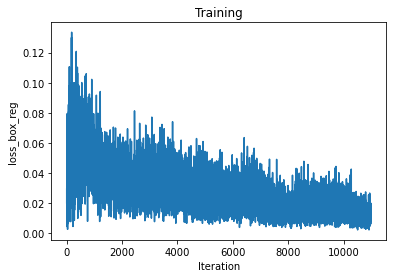

In [20]:
# Plot loss during training 
y = np.genfromtxt("model.csv")[1:] 
x = np.arange(y.shape[0]) 

plt.plot(x, y) 
plt.xlabel("Iteration") 
plt.ylabel("loss_box_reg") 
plt.title("Training") 

plt.show() 

# Test model

In [21]:
test_files = test["files"] 
train_files = train["files"] 
model_path = "sample.pt"
checkpoint = torch.load(model_path)
model_state_dict = checkpoint["hyper_parameters"]["model"]

In [22]:
model_state = model_state_dict.state_dict() 
model.load_state_dict(model_state) 
model = model.eval() 

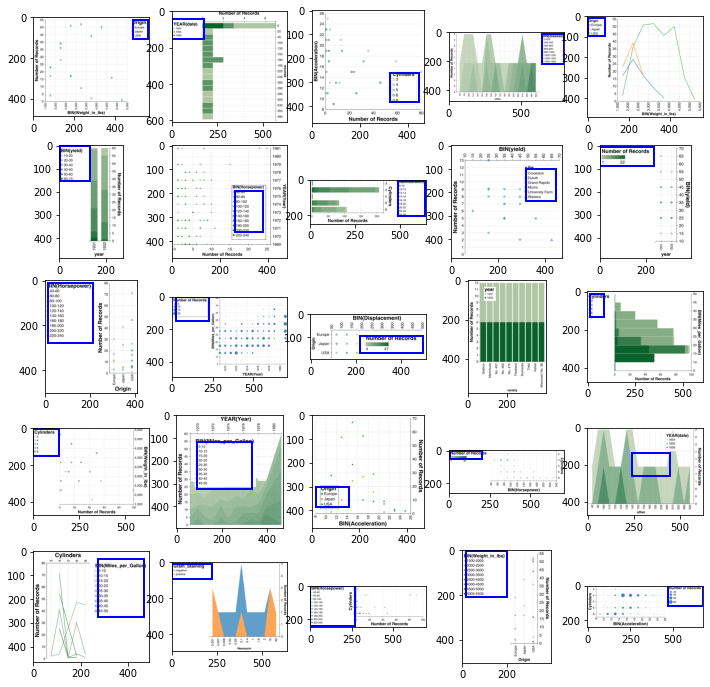

In [23]:
test_files = test["files"] 

_, axs = plt.subplots(5, 5, figsize = (12, 12))  
axs = axs.flatten()
naxs = len(axs) 
for file, ax in zip(test_files[:naxs], axs[:naxs]): 
    with torch.no_grad(): 
        img = torch.from_numpy(plt.imread(file)) 
        # Reshape image 
        img = img.reshape(3, *img.shape[:2])   
        prediction = model([img]) 
        
        rect = None 
        
        if len(prediction[0]["boxes"]) > 0: 
            bbox = prediction[0]["boxes"][0] 
            x, y = bbox[0], bbox[1] 
            width, height = bbox[2] - x, bbox[3] - y 
            rect = patches.Rectangle((x, y), width, height, 
                                    facecolor = "none", 
                                    edgecolor = "blue", 
                                    linewidth = 2) 
        ax.imshow(img.reshape(*img.shape[1:], 3)) 
        if rect: ax.add_patch(rect) 
plt.show() 

# Bibiliography 

The inital goal of the presentation was to introduce a pair of research topics: object detection and automatic chart analysis; the subsequent objective was the exploration of the influence of the latter in the former. In this context, the [slides](./rcnn.pdf) contain a historical summary and the current state-of-the-art for addressing the detection of objects in images; correlatively, an implementation with PyTorch is available in the [Jupyter Notebook](./RCNN.ipynb). 

However, the slides are possibly overfilled with quotes and references; then, we aim, with this README.md, to provide a more appropriate description of each paper, explicitly writing their objectives and how they influenced the current shape of this awesome branch of science! For this, we will sort the documents according to the date of publication. 

+ [Efficient graph-based image segmentation](https://link.springer.com/article/10.1023/B:VISI.0000022288.19776.77) (2004). There isn't a panacea to science, nor to anything; in particular, algorithms to segment images (that is, to partition the image, which is a set of pixels, attributing to each pixel a label according to a set of predefined labels) existed way before way before deep learning, and they were pretty okay. In this paper, for instance, Felzenszwalb and Huttenlocher propose an graph-based procedure that (1) instantiates a weighed graph in which the vertices are the pixels (the weights are a measure of dissimilarity between the pixels) and (2) searchs for connected components whose internal similarity is substantially discrepant from the external dissimlarity; those connected components compose the segmentation. 

+ [Imagenet classification with deep convolutional neural networks](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) (2012). This is THE paper for image classification with CNNs; historically, it presented to the world the strength of deep learning to classify images in a time in which heruristic procedures were the rulers of this branch of science. Also, it proposed the famous and actually known as AlexNet's architecture (named after [Alex Krizvhesky](https://www.cs.toronto.edu/~kriz/)) for CNNs; yet the paper was published in 2012, it is still important and used today, being the foundation of [Caffe](https://caffe.berkeleyvision.org/) framework. 

+ [Selective search for object recognition](https://link.springer.com/article/10.1007/s11263-013-0620-5) (2013). The graph-based algorithm designed in Felzenswalb's 2004 paper was an important piece in the duel with object detection; but it proposed many regions, way more than was semantically plausible. In this scenario, Uijlings and his partners designed a greedy algorithm to merge the regions computed by Felzenswalb's procedure (it used some heuristic methods; for instance, it should conveniently merge regions in which one is the boundary of the other); this would posteriorly be the main component of deep learning based methods for object classification. 

+ [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/abs/1311.2524) (2014). We already have papers that aim to partition an image in semantically convenient regions, which are images themselves; we also have methods for addressing the classification of figures in general (for instance, Alex seminal work). What is the next step? You know it! Join everything in a unified system that starts with a set of some thousands of regions and then classify them using the feature vector extracted with a convolutional neural network; that is exactly what was designed in Girshick's (and partners') paper. Precisely, the framework started with the computations of auspicious regions with Selective Search's algorithm; with this, a feature vector was, with a deep convolutional neural network, extracted for each region and subjected to classification with an SVM: the whole framework was called RCNN ("Regions with CNN"). 

+ [Spatial pyramid pooling in deep convolutional networks for visual recognition](https://arxiv.org/abs/1406.4729) (2014). We are well informed that the convolutional neural networks are the game changer of, oh, possibly (almost) everything? However, they have a inappropriate property: their inputs must be of fixed sizes; that is, the image must have a adequate quantity of pixels and those pixels must be arranged in a adequate grid with adequate dimensions. Those adequations, however, are strong; we usually, for instance, need to reshape the input image to feed forward it to in a CNN, generating an conveniently sized feature vector. In this context, He, Zhang, Ren and Sun proposed a framework that aimed to accept arbitrarily shaped images; for this, they inserted an adaptative pooling layer (more accurately, a layer whose architecture is conditinal to the structure of the input image) that would culminante in a feature vector of appropriate size. It was OK for the time; but the training was excessively cumbersome. 

+ [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/abs/1409.1556) (2015). When we design a CNN, we must be careful in the choice of hyperparameters; importantly, we must decide whether it should be deep or shallow. In this paper, Simonyan and Zisserman designed a deep learning framework with more than 15 layers for image classification and recognition; and it was awesome. Currently, we call it the VGG-16 architecture; VGG is the name of the research group that studied it (Visual Geometry Group, in the University of Oxford) and 16 was, in the time of its publication, the next year. 

+ [Fast R-CNN](https://arxiv.org/abs/1504.08083) (2015). [Ross Girshick](https://www.rossgirshick.info/) proposed, in 2014, the RCNN framework; albeit its historical importance -- as it is written in the slides, it was the spark that lightened the path for the design of more appropriate procedures --, it doesn't appropriately share the computation between pixels. Precisely, RCNN independently classify each region; in particular, it must feed forward a CNN (VGG!) for each proposal, which is computationally exhaustive. Girshick, then, proposed modifying RCNN's architecure: in Fast RCNN, the image is initially feed forwarded in the convolutional neural network, generating a feature map; then, we project the proposals computed with the Selective Search algorithm and classify those projections using a fully connected layer neural network. Therefore, the proposals are still computed with a heuristic procedure, but we have an complete procedure that can be jointly trained to label objects in images; the current state-of-the-art, however, would unfold with the next RCNN. 

+ [Faster R-CNN: Towards real-time object detections with regions proposal networks](https://arxiv.org/abs/1506.01497) (2016). Ren, He and Sun, the designers of the Spatial Pyramid Pooling architecture for arbitrarily shaped inputs in CNNs, and Girshick, the computer scientist that introduced RCNN and Fast RCNN, joined, in 2016, to delineate a fully trainable and completely deep learning based system for object recognition and classification; precisely, they designed a Region Proposal Network (RPN), whose objective is to generate the regions to be classified with Fast RCNN. The culmination of this was, so, the Faster RCNN; it is still a robust lightsaber that computer vision scientists use to duel with the dark side of the semantic description of images. 

+ [Lecture 11: Detection and segmentation](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf) (2017). In the University of Standford, they have a course specifcally designed for the applications of convolutional neural networks in visual recognition tasks; it is named criptically for foreigners -- [CS231n](http://cs231n.stanford.edu/) --, but you can watch their classes with lovely professors on [YouTube](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv). 

+ [Chart mining: A survey of methods for automated chart analysis](https://ieeexplore.ieee.org/document/9085944) (2021). In our presentation, there was a duality: on the one hand, we should introduce the wide topic of object detection; on the other hand, we needed to provide some aspects of the possibly esoteric area of automatic chart analysis. For this task, we described what are our intentions when we write about automatically describing charts, and why it is worth researching about it; but we didn't write about the actual methods that people use in this instance of semantic description of images. However, if your objects contemplate the profound exploration of this topic, Davila and his partners provide a structured and recent review of the main methods for extracting information of charts; in particular, they explore the extraction of data from bitmap chart images and the generation of publicly annotated data sets. 

Also, other references didn't directly shape the slides nor the presentation, but possibly it is worth writing about them: [Mask RCNN](https://arxiv.org/abs/1703.06870), for instance, is a deep learning method for image segmentation (that is, it aims to assign to each pixel in a image a label, in opposition to the computation of a bounding box that covers an object which we desire to detect); [this](https://idl.cs.washington.edu/papers/reverse-engineering-vis/) paper, on the other hand, proposed a complete system to generate the specification (that is, the visual encondings, specifically the textual visual encondings) of bitmap chart images; and [this](https://ieeexplore.ieee.org/document/8017646) designed a system to extract and update the color mappings in bitmap image visualizations (but the pipeline required a human intervation to label the region in which the legend with the color mapping was; our implementation aims to automate this step). 
 

